In [63]:
import torch
from transformers import AutoTokenizer, DebertaForSequenceClassification
from torch.nn.functional import softmax
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import gradio as gr

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from wordcloud import WordCloud

In [64]:
#deberta大模型方法
def load_model(model_path, device):
    # 加载预训练的 BERT 模型结构，设置分类任务的输出标签数量为 2（可以根据你的任务调整）
    model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=2)
    # 加载自定义的模型权重
    model.load_state_dict(torch.load(model_path), strict=False)
    # 将模型移动到 GPU 或 CPU
    model.to(device)
    # 设置模型为评估模式（禁用dropout等）
    model.eval()
    return model
def predict_spam(text):
    # 对输入文本进行编码
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        # 获取模型的输出
        outputs = model(**inputs)
        logits = outputs.logits
        # 使用softmax函数获取概率
        probabilities = softmax(logits, dim=1)
        # 获取预测类别
        pred_class = torch.argmax(probabilities, dim=1)
        # 返回概率和预测类别
        return probabilities[0][1].item(), pred_class.item()

def read_file(file_path):
    """尝试用多种编码读取文件，处理编码错误"""
    encodings = ['utf-8', 'latin-1', 'ISO-8859-1', 'GBK']
    for enc in encodings:
        try:
            with open(file_path, 'r', encoding=enc) as file:
                return file.read()
        except UnicodeDecodeError:
            print(f"使用编码 {enc} 读取失败，尝试其他编码...")
    raise ValueError(f"无法读取文件: {file_path}，请检查文件编码。")

The dataset has 5572 rows and 2 columns.


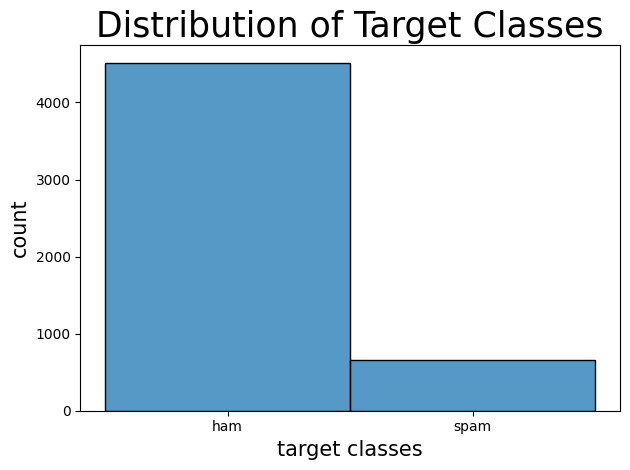

In [65]:
#贝叶斯方法
### 读入观察数据
data = pd.read_csv('./spam.csv', encoding='ISO-8859-1')
data.head()

pd.set_option('display.max_colwidth',None)
### 将不需要的列删除，并将列开头重新命名
data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
data.rename(columns={'v1':'label','v2':'text'},inplace=True)
### 数据总量
print('The dataset has {} rows and {} columns.'.format(data.shape[0],data.shape[1]))

### 数据无缺失
data.isna().sum()
### 查重
data.duplicated().sum()
### 去重
data.drop_duplicates(inplace=True)
data.duplicated().sum()

## 看一下数据分布直方图
sns.histplot(data=data,x='label')
plt.title('Distribution of Target Classes',fontsize=25)
plt.xlabel('target classes',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.tight_layout()

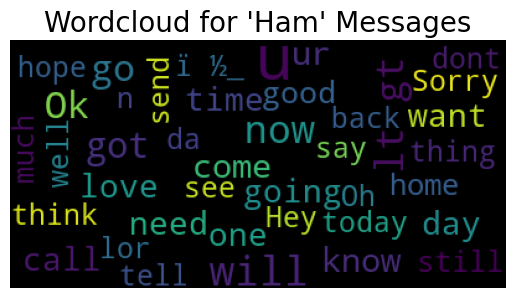

In [66]:
### 检测正常邮件中出现最多的词
text = ' '.join(data[data['label']=='ham']['text'])
wordcloud = WordCloud(max_font_size=50,max_words=40).generate(text)
### 显示
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud for 'Ham' Messages",fontsize=20)
plt.show()

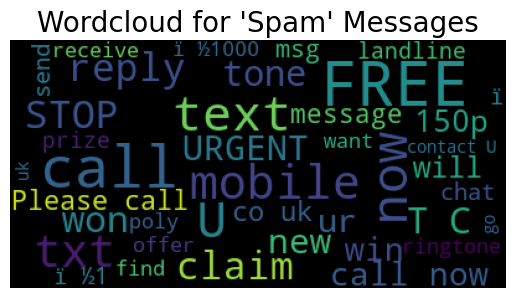

,model,precision,recall,F1,accuracy
0,MNB (train),0.987111,0.981266,0.984164,0.993367
0,MNB (test),0.980801,0.954940,0.967347,0.984526


In [67]:
### 检测垃圾邮件中出现最多的词
text = ' '.join(data[data['label']=='spam']['text'])
wordcloud = WordCloud(max_font_size=50,max_words=40).generate(text)

### 显示
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Wordcloud for 'Spam' Messages",fontsize=20)
plt.show()

X = data['text']
y = data['label']
### 划分训练集测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

X_train.count()

def get_test_scores(model_name:str,preds,y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table 

### 提取文本特征
featurizer = CountVectorizer(decode_error='ignore')  # The option "decode_error='ignore'" is set to take care of the wrongly decoded characters
### 提取特征
X_train2 = featurizer.fit_transform(X_train)
X_test2 = featurizer.transform(X_test)

### 贝叶斯
MNB = MultinomialNB()
MNB.fit(X_train2,y_train)

MNB_train_preds = MNB.predict(X_train2)
MNB_train_results = get_test_scores('MNB (train)',MNB_train_preds,y_train)

MNB_test_preds = MNB.predict(X_test2)
MNB_test_results = get_test_scores('MNB (test)',MNB_test_preds,y_test)

MNB_results = pd.concat([MNB_train_results,MNB_test_results],axis=0)
MNB_results

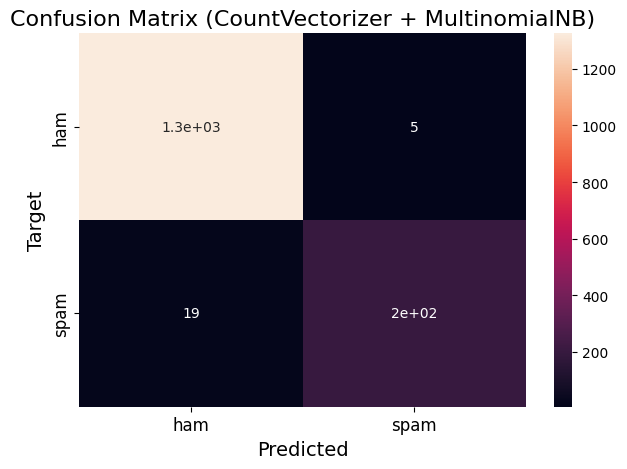

In [68]:
### 混淆矩阵测试性能
cm = confusion_matrix(y_test,MNB_test_preds,labels=MNB.classes_)
ax = sns.heatmap(cm,annot=True)
ax.set_title('Confusion Matrix (CountVectorizer + MultinomialNB)',fontsize=16)
ax.xaxis.set_ticklabels(['ham','spam'],fontsize=12) 
ax.yaxis.set_ticklabels(['ham','spam'],fontsize=12) 
ax.set_xlabel("Predicted",fontsize=14)
ax.set_ylabel("Target",fontsize=14)
plt.tight_layout()

# 保存图像
plt.savefig('confusion_matrix.jpg', format='jpg')


train AUC: 0.9903673034322985
test AUC: 0.9840345604808415


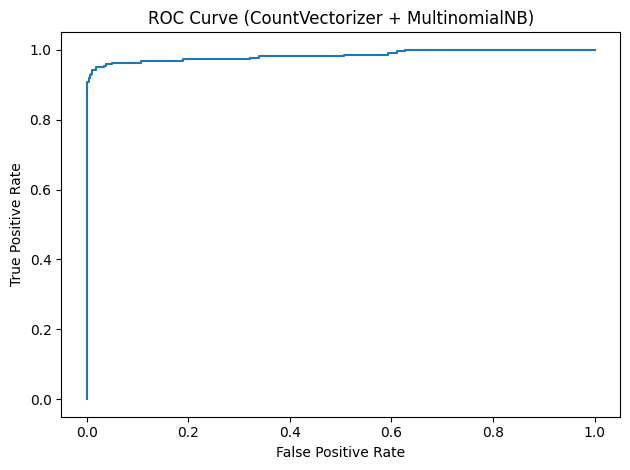

In [69]:
prob_train = MNB.predict_proba(X_train2)[:,1]
prob_test  = MNB.predict_proba(X_test2)[:,1]
print("train AUC:",roc_auc_score(y_train,prob_train))
print("test AUC:",roc_auc_score(y_test,prob_test))

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train2 = encoder.fit_transform(y_train) 
y_test2  = encoder.fit_transform(y_test) 

from sklearn.metrics import roc_curve
def plot_roc_curve(true_y,y_prob,text):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y,y_prob)
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve {text}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout()
    # 保存图像
    plt.savefig('plot_roc_curve.jpg', format='jpg')
plot_roc_curve(y_test2,prob_test,'(CountVectorizer + MultinomialNB)')



def predict_spam_or_ham(input_text, model, featurizer):
    """
    输入文本，使用训练好的模型进行垃圾邮件预测。
    参数:
    - input_text: 用户输入的文本
    - model: 训练好的模型 (MultinomialNB)
    - featurizer: 用于将文本转化为特征向量的向量化器 (CountVectorizer)
    返回:
    - 预测结果 (Spam or Ham)
    - 预测的概率
    """
    # 将输入文本转化为特征向量
    input_features = featurizer.transform([input_text])
    
    # 预测结果
    prediction = model.predict(input_features)
    prediction_proba = model.predict_proba(input_features)

    # 输出预测结果
    print(f"\n输入的文本: {input_text}")
    print(f"预测的类别: {'Spam (垃圾邮件)' if prediction[0] == 'spam' else 'Ham (正常邮件)'}")
    print(f"预测的概率: {prediction_proba}")
    
    return prediction[0], prediction_proba

In [70]:
if __name__ == '__main__':
    model_path = 'deberta_model_v1.pth'  # 你保存的模型权重文件
    device = torch.device('cpu')
    # 加载模型
    model = load_model(model_path, device)

    # 加载 BERT 预训练的 tokenizer
    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-base")

    csv_file_path = 'spam.csv'  # 替换为你的CSV文件路径
    df = pd.read_csv(csv_file_path)
    true_labels = df['v1'].apply(lambda x: 1 if x == 'Ham' else 0).tolist()
    texts = df['v2'].tolist()
    labels = df['v1'].tolist()
    predictions = []
    success = 0
    total = len(true_labels)  # 样本总数
    print(f"总数：{total}")

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\wenjie\AppData\Local\Temp\ipykernel_11412\3755771862.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

总数：5572


In [100]:
#gradio部分代码
def greet(sample_text):
    #deberta 
    if predict_spam(sample_text)[1] == 1:
        deberta_pre = 'ham'
        deberta_gai = predict_spam(sample_text)[0]
    else:
        deberta_pre = 'spam'
        deberta_gai = 1-predict_spam(sample_text)[0]
    #贝叶斯方法
    b_pre = predict_spam_or_ham(sample_text, MNB, featurizer)[0]
    b_gai = predict_spam_or_ham(sample_text, MNB, featurizer)[1]
    #final
    if b_pre == 'ham':
        beiyesi = 1
        b_gai =b_gai[0][0]
    elif b_pre == 'spam':
        beiyesi = 0
        b_gai = b_gai[0][1]
    final = predict_spam(sample_text)[1] *0.3 + beiyesi *0.7
    if final > 0.5:
        final_pre = 'ham'
    else:
        final_pre = 'spam'
    return deberta_pre,deberta_gai,b_pre,b_gai,final_pre
styles = """
<style>
    .label {
    color: blue !important;
    font-weight: bold !important;
    }
</style>
"""
demo = gr.Interface(
    fn=greet,
    inputs=["text"],
    outputs=["text","text","text","text","text"],
    title="垃圾邮件检测",
    css = styles
    
)

def update_image(selection):
    if selection == 'deberta：训练收敛曲线':
        return "./shoulian.jpg"
    elif selection == 'deberta：混淆矩阵':
        return "./mix.png"
    else:
        return "./1.jpg"

def update_image2(selection):
    if selection == '贝叶斯：混淆矩阵':
        return "./confusion_matrix.jpg"
    elif selection == '贝叶斯：ROC曲线':
        return "./plot_roc_curve.jpg"
    else:
        return "./1.jpg"
# 本地图片的文件路径
image_path = "./1.jpg"  # 替换为你的图片文件路径
# 使用 Blocks 模式创建自定义布局的界面
with gr.Blocks(css=styles) as demo:
    with gr.Row():
        with gr.Column():
            gr.Markdown(value="<h1 style='text-align: center; font-size:40px'>垃圾邮件检测</h1>")
            gr.Markdown(value="<h1 style='text-align: center;font-size:10px'>上海大学通信学院自然语言处理课程项目展示</h1>")
            gr.Markdown(value="<h1 style='text-align: center;font-size:10px'>指导老师：张琦；组长：白洁松</h1>")
            gr.Markdown(value="<h1 style='text-align: center;font-size:10px'>组员：陈鲲鹏，闫文杰，殷煜昊，张尊义</h1>")
        gr.Image(value=image_path, label="本地图片", visible=True,width=250, height=150 )
    input_text = gr.Textbox(label="输入文本", elem_classes=".label")
    with gr.Row():
        with gr.Column():
            output_text1 = gr.Textbox(label="大模型方法预测结果")
            output_text2 = gr.Textbox(label="准确率")
        with gr.Column():
            output_text3 = gr.Textbox(label="贝叶斯方法预测结果")
            output_text4 = gr.Textbox(label="准确率")
    output_text5 = gr.Textbox(label="最终预测结果")
    # 添加选择按钮
    with gr.Row():
        with gr.Column():
            image_selector = gr.Radio(label="deberta模型训练效果", choices=['deberta：混淆矩阵', 'deberta：训练收敛曲线'], value=1)
            image_display = gr.Image(label="选择的图片")  
        with gr.Column():
            image_selector2 = gr.Radio(label="贝叶斯模型训练效果", choices=['贝叶斯：混淆矩阵' ,'贝叶斯：ROC曲线'], value=1)
            image_display2 = gr.Image(label="选择的图片")  
    # 将输入和输出连接到 greet 函数
    input_text.change(fn=greet, inputs=[input_text], outputs=[output_text1, output_text2,output_text3, output_text4,output_text5])
    image_selector.change(fn=update_image, inputs=image_selector, outputs=image_display)
    image_selector2.change(fn=update_image2, inputs=image_selector2, outputs=image_display2)

demo.launch() 


* Running on local URL:  http://127.0.0.1:7912

To create a public link, set `share=True` in `launch()`.



输入的文本: a
预测的类别: Ham (正常邮件)
预测的概率: [[0.88032062 0.11967938]]

输入的文本: a
预测的类别: Ham (正常邮件)
预测的概率: [[0.88032062 0.11967938]]

输入的文本: asdasdasdasdasd
预测的类别: Ham (正常邮件)
预测的概率: [[0.88032062 0.11967938]]

输入的文本: asdasdasdasdasd
预测的类别: Ham (正常邮件)
预测的概率: [[0.88032062 0.11967938]]

输入的文本: 	v2
9	WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
预测的类别: Spam (垃圾邮件)
预测的概率: [[2.68593347e-16 1.00000000e+00]]

输入的文本: 	v2
9	WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
预测的类别: Spam (垃圾邮件)
预测的概率: [[2.68593347e-16 1.00000000e+00]]

输入的文本: 	v2
11	I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.
预测的类别: Ham (正常邮件)
预测的概率: [[1.00000000e+00 6.81809581e-12]]

输入的文本: 	v2
11	I'm gonna be home soon and i don't want to talk about this stuff 